### Atributos de Textura de 1$^a$ ordem

Os seguintes valores são calculado com o histograma e são largamente utilizados para representar imagens:
- Média
- Variância
- Skewness
- Kurtosis
- Energia
- Entropia




# Atividade: 

## Implementar os atributos acima em uma imagem.

In [1]:
import torch
from PIL import Image
from torch.utils.data import DataLoader,TensorDataset,ConcatDataset
from torch import optim
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import seaborn as sns

%matplotlib inline

/home/killeglass/anaconda3/envs/yolo/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<font size=6 color=darkblue> Definindo classificador e treinamento

In [2]:
class classficador_torch(nn.Module):

  def __init__(self, input, out):
    super().__init__()
    #criando as camadas convulocionais

    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(1*  6, 3),
      nn.ReLU(),
      nn.Linear(3 , 3 ),
      nn.ReLU(),
       nn.Linear(3 , 3 ),
      nn.ReLU(),
      nn.Linear(3, out)
    )


  def forward(self,x):

    return self.layers(x)

In [3]:

def forward(model=None,inputs=None,labels=None,mode=None, criterio=None,optimizer=None):

  loss = 0
  if mode == 'Training':
    optimizer.zero_grad()

  inputs , labels = inputs.cuda(), labels.cuda()

  outputs = model(inputs)#classificador.forward é a mesma coisa, camada de aprendizado

  if mode == 'Training':
    
    loss = criterio(outputs,labels)#calculando o erro
    loss.backward()
    optimizer.step()


  #_, preds = torch.max(outputs, 1)

  #accuracy =  (preds == labels).float().mean()
  
  res_p, res_class = F.softmax(outputs).topk(k=1, dim = 1)
  #verificando se o classificador acertou ou errou, depois de fazer uma comparaçao entre os vetores de boleanos
  #se faz a media
  accuracy = torch.mean((res_class == labels.view(*res_class.shape)).type(torch.float))

  
  if mode == "Training":
    return model, loss, accuracy, optimizer
  
  elif mode == "Testing":
    return accuracy

In [4]:
def train(train_loader,mlp, criterio, optimizer,epochs):

    mlp.train()
    best = 0
    earlyStop = 0
    patience = 10
    counter = 0

    for epoch in range(epochs):
        running_loss = 0
        running_acurracy = 0

        for i,data in enumerate(train_loader):
            #inputs sao entradas, previsores. Labels as respostas reais
            inputs, labels = data
            #zerando os gradientes. Gradientes é a direção para onde vai ser feito os ajustes do peso 

            mlp, loss, accuracy, optimizer = forward(mlp,inputs,labels,"Training",criterio,optimizer)

            running_loss += loss.item()

            running_acurracy += accuracy

            #print("Epocas: {}| Iteração {} | Loss: {:.5f} | Precisao {:03.2f}".format(epoch+1,i + 1, loss,accuracy))


        #salvando melhor modelo
        if best < running_acurracy/len(train_loader):
            best = running_acurracy/len(train_loader)
            model = mlp
            
        if best > running_acurracy/len(train_loader):
            counter += 1
            if counter > patience:
                print("Early Stopping!!")
                break
            else:
                counter = 0
        
    print("Epocas: {} | Loss: {:.5f}, Precisao {:.2f}".format(epoch+1,running_loss/len(train_loader), running_acurracy/len(train_loader)))

    return mlp, model

In [5]:
def test(testLoader,mlp):
  
  running_acurracy = 0
  for i,data in enumerate(testLoader):
    #inputs sao entradas, previsores. Labels as respostas reais
    inputs, labels = data
    
    accuracy = forward(model=mlp,inputs=inputs,labels=labels,mode="Testing")

    running_acurracy += accuracy
  
  print("Precisão do test: ",running_acurracy/len(testLoader))
  return running_acurracy/len(testLoader)

<font size=6 color=darkblue> Extração de caracteristicas e pré-processamento

In [6]:
class Alargamento():
    
    def __init__(self, K , E):
        self.K = K
        self.E = E

    def __call__(self,image):
        return 1/(1 + (self.K /image)** self.E)
    
    
    
class Negativo():
    
    def __init__(self, limi = 255):
        self.limiar = limi

    def __call__(self,image):
        return self.limiar - image


class Logaritimica():
    
    def __init__(self, c):
        self.c = c

    def __call__(self,image):
        return self.c * torch.log(1 + image)


class Potencia():
    
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self,image):
        return (image / 255) ** self.gamma * 255

In [7]:
#tentar entender depois
def entropy(input_tensor):
    log_probs = F.log_softmax(input_tensor, -1)
    probs = torch.exp(log_probs)
    p_log_p = log_probs * probs
    entropy = -p_log_p.mean()
    return entropy

In [8]:
def descritor_histograma(imagem):
    # calcula histograma
    hist = torch.histc(imagem)


    # calcular atributos
    mean = torch.mean(hist)
   
    diffs = hist - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    sk = torch.mean(torch.pow(zscores, 3.0))
    kur = torch.mean(torch.pow(zscores, 4.0)) - 3.0 
    
    ener = torch.sum(torch.tensor([x**2 for x in hist])/len(hist))
    entr = entropy(hist)
 
    return torch.tensor([mean,var,sk,kur,ener,entr])


In [9]:
def dataloader(data,isTorch):
    
    listImg = []
    listLab = []
    for img, label in data:
        des = descritor_histograma(img)

        #if isTorch:
        listImg.append(des)
        listLab.append(label)
 
     
    if isTorch: 
        listImg = torch.stack(listImg,0)
        listLab = torch.tensor(listLab)
        dataset = TensorDataset(listImg,listLab)  
        loader = DataLoader(dataset, batch_size=60, shuffle=True )
    else:
       loader = (listImg,listLab) 
        
    return loader

- Utilizar a base de imagens do trabalho anterior
- Calcular os atributos de primeira ordem para cada imagem, e criar uma matriz
- Plotar os atributos dois a dois (scatter plot)
- A entrega será:
    - Notebook com os códigos;
    - Short paper de até 4 páginas com:
        - Introdução: apresentar o problema/base escolhida;
        - Metodologia: explicar os atributos e como são calculados;
        - Resultados: resultado da classificação e scatter plots dos atributos;
        - Extra: plotar os atributos utilizando um algoritmo de redução de dimensionalidade, ex: PCA, t-SNE;
        - Conclusão.
- Entrega e apresentação: 20/12/2022

<font size=6 color=darkblue> Definindo treinamento

In [10]:

def classification(trainLoader, testLoader, input, out, epoch):
    
    
    #definindo parametros de treinamento
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mlp = classficador_torch(input,out)
    criterio = nn.CrossEntropyLoss()#funçao de perda
    #criterio = nn.MarginRankingLoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)
    #optimizer = torch.optim.SGD(mlp.parameters(),lr=0.001, momentum=0.9)
    mlp.to(device)
    
    
    model = train(trainLoader,mlp,criterio, optimizer,epoch)
    mlp.eval()
    acc = test(testLoader,mlp)
    
    return acc

In [11]:
def trainPre(pathTrain,pathTest,pros,listPara,k):
    
    listAcc = {}
    f = 0
    tfPre= None
    for i in listPara:
        if pros == "Potencia":
            tfPre= transforms.Compose([transforms.ToTensor(),transforms.Grayscale(), Potencia(i)])
        
        elif pros == "Logaritimica":
            tfPre= transforms.Compose([transforms.ToTensor(),transforms.Grayscale(), Logaritimica(i)])
            
        elif pros == "Negativo":
            tfPre= transforms.Compose([transforms.ToTensor(),transforms.Grayscale(), Negativo(i)])
            
        elif pros == "Alargamento":
            tfPre= transforms.Compose([transforms.ToTensor(),transforms.Grayscale(), Alargamento(k[f],i)])
            f += 1
    
    
        dataTrainPre = datasets.ImageFolder(pathTrain, transform=tfPre)
        dataTestPre = datasets.ImageFolder(pathTest, transform=tfPre)
        trainLoader = dataloader(dataTrainPre,True)
        testLoader = dataloader(dataTestPre,True)
        acc =classification(trainLoader,testLoader, 1 * 6, 4, 200)
        
        listAcc[i] = acc
        
    return listAcc
    

<font size=6 color=darkblue> Carregando os dados

In [12]:
#carregando os dados
tf= transforms.Compose([transforms.ToTensor(),
                        transforms.Grayscale()]
    )

pathTrain = '../training'
dataTrain = datasets.ImageFolder(pathTrain, transform=tf)
pathTest  = '../testing'
dataTest = datasets.ImageFolder(pathTest, transform=tf)

out = len(dataTrain.class_to_idx)
names = {x:i for i,x in dataTrain.class_to_idx.items()}

In [13]:
#teste normal
trainLoader = dataloader(dataTrain,True)
testLoader = dataloader(dataTest,True)
acc =classification(trainLoader,testLoader, 1 * 6, out, 200)

/tmp/ipykernel_11279/2704663836.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res_p, res_class = F.softmax(outputs).topk(k=1, dim = 1)


Epocas: 200 | Loss: 1.39080, Precisao 0.24
Precisão do test:  tensor(0.4133, device='cuda:0')


In [14]:
#teste com Potencia
k = False
potenci= [ 0.4 ,  0.6 ,3 ,4 ,5]
p =trainPre(pathTrain,pathTest,"Potencia",potenci,k)


#teste com Logaritimica
Logar = [ 0.1 , 0.5 , 1 , 5]
l = trainPre(pathTrain,pathTest,"Logaritimica",Logar,k)

#teste com Logaritimica
Negat = [255]
n = trainPre(pathTrain,pathTest,"Negativo",Negat,k)


#teste com Alargamento
E = [2,3,4,5,2,2,2]
k = [5,5,5,5,10,15,20]
e = trainPre(pathTrain,pathTest,"Alargamento",E,k)

/tmp/ipykernel_11279/2704663836.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res_p, res_class = F.softmax(outputs).topk(k=1, dim = 1)


Epocas: 200 | Loss: 118226.29811, Precisao 0.27
Precisão do test:  tensor(0.2167, device='cuda:0')
Epocas: 200 | Loss: 7962.28482, Precisao 0.24
Precisão do test:  tensor(0.0267, device='cuda:0')
Epocas: 200 | Loss: 1.47807, Precisao 0.25
Precisão do test:  tensor(0.0333, device='cuda:0')
Epocas: 200 | Loss: 94.91906, Precisao 0.25
Precisão do test:  tensor(0.3133, device='cuda:0')
Epocas: 200 | Loss: 1.45128, Precisao 0.26
Precisão do test:  tensor(0.2300, device='cuda:0')
Epocas: 200 | Loss: 3.81917, Precisao 0.24
Precisão do test:  tensor(0.3667, device='cuda:0')
Epocas: 200 | Loss: 71335.79071, Precisao 0.26
Precisão do test:  tensor(0.3700, device='cuda:0')
Epocas: 200 | Loss: 1.40687, Precisao 0.24
Precisão do test:  tensor(0.3700, device='cuda:0')
Epocas: 200 | Loss: 46184.07288, Precisao 0.24
Precisão do test:  tensor(0.0800, device='cuda:0')
Epocas: 200 | Loss: 180097.59868, Precisao 0.26
Precisão do test:  tensor(0.3700, device='cuda:0')
Epocas: 200 | Loss: 1.41794, Precisao 

In [15]:
print(p)


{0.4: tensor(0.2167, device='cuda:0'), 0.6: tensor(0.0267, device='cuda:0'), 3: tensor(0.0333, device='cuda:0'), 4: tensor(0.3133, device='cuda:0'), 5: tensor(0.2300, device='cuda:0')}


In [16]:
print(l)

{0.1: tensor(0.3667, device='cuda:0'), 0.5: tensor(0.3700, device='cuda:0'), 1: tensor(0.3700, device='cuda:0'), 5: tensor(0.0800, device='cuda:0')}


<font size=6 color=darkblue> Criando plots

In [17]:

img, lab = dataloader(dataTrain, False)
names = ["Mean","Var","Sk","Kur","Ener","Entr"]
df = pd.DataFrame(img, columns = names)

nomes = ['Glioma',"Meningioma","No_tumor","Pituitary"]
for i in range(len(lab)):
    lab[i] = nomes[lab[i]]
dfPlot = df.copy()
df['Classe'] = lab

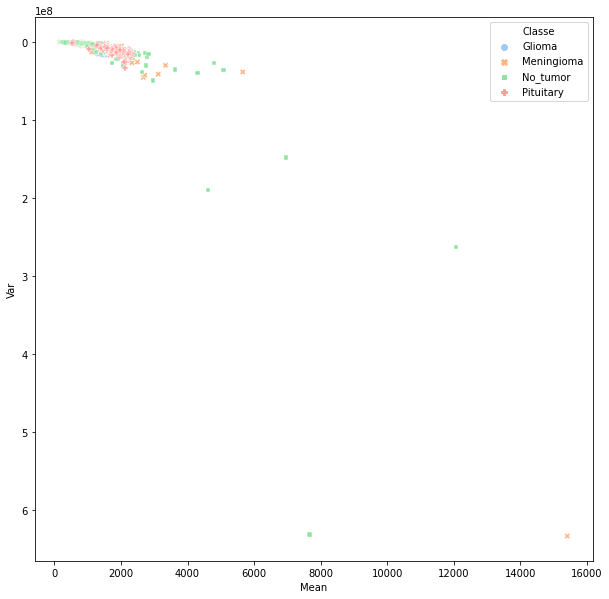

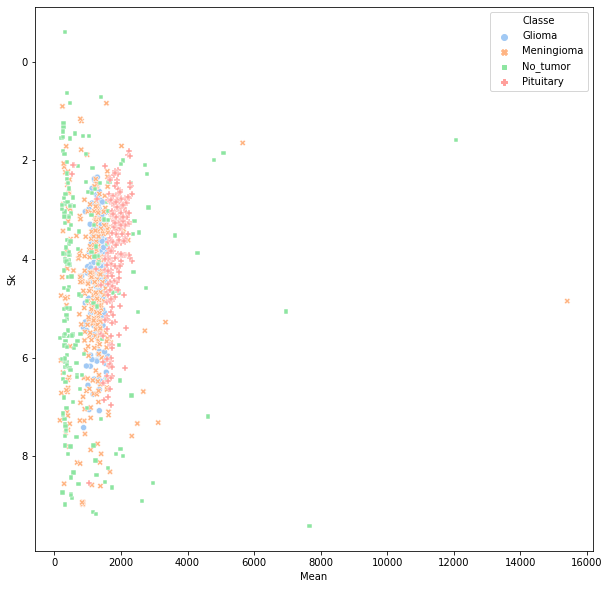

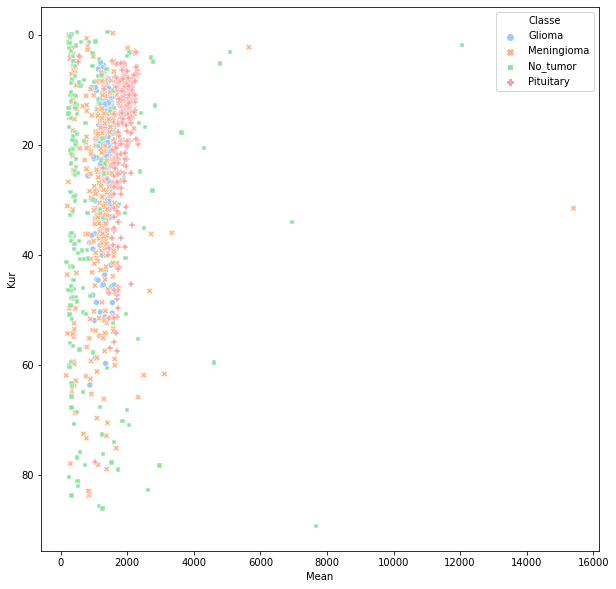

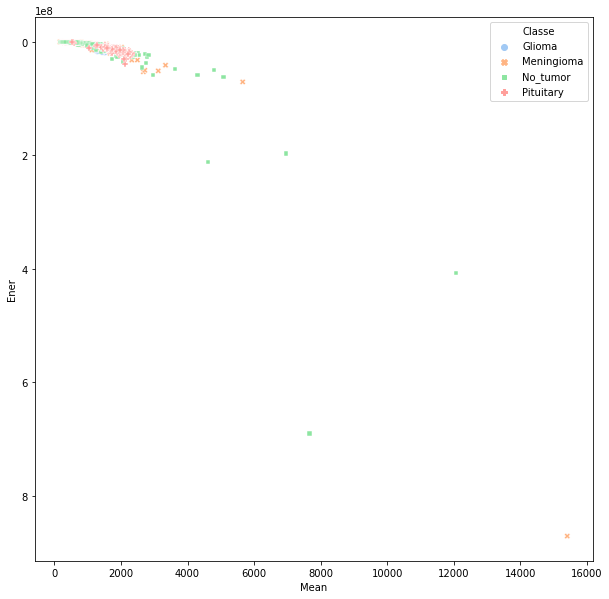

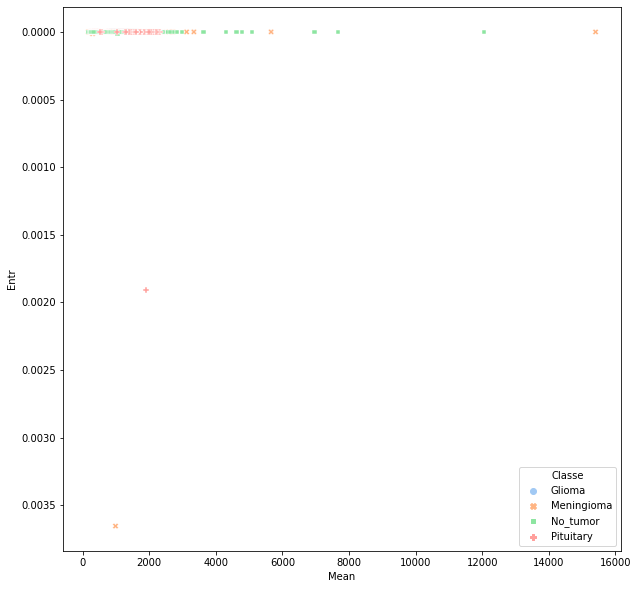

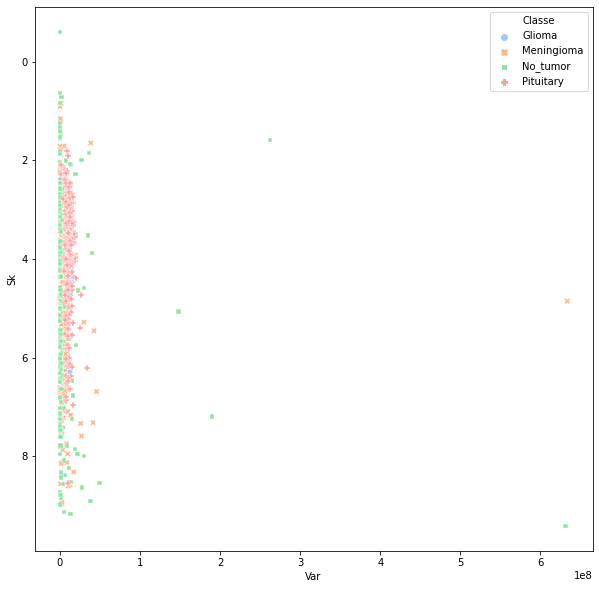

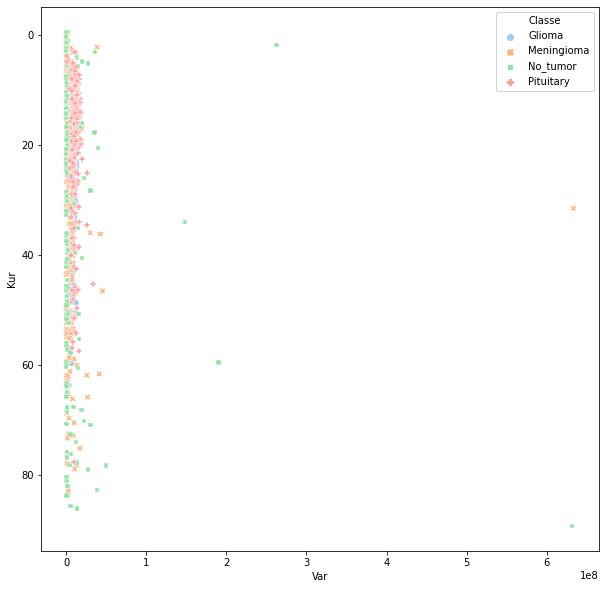

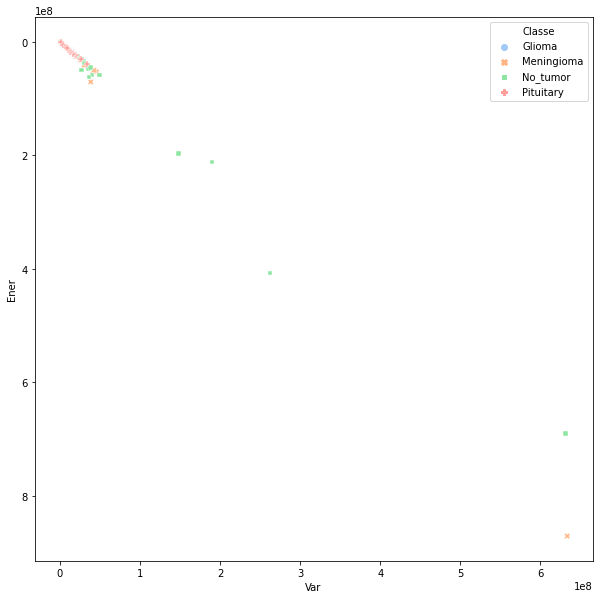

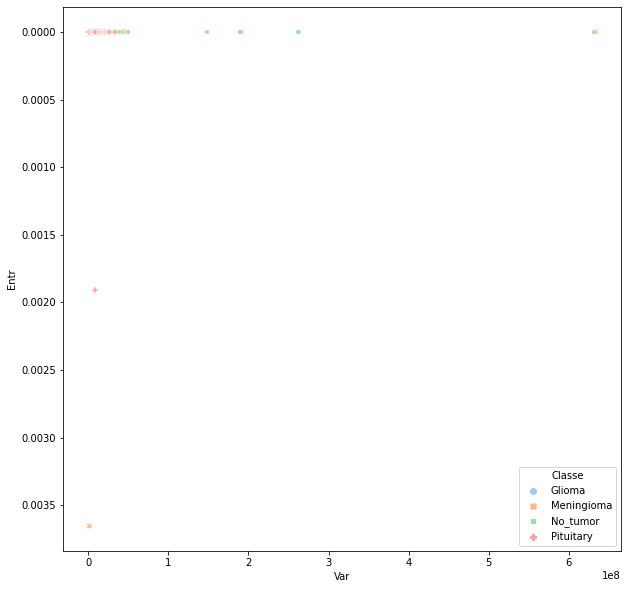

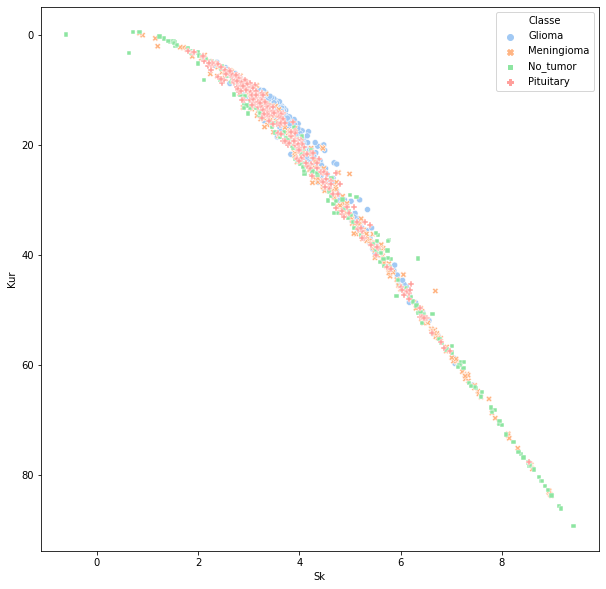

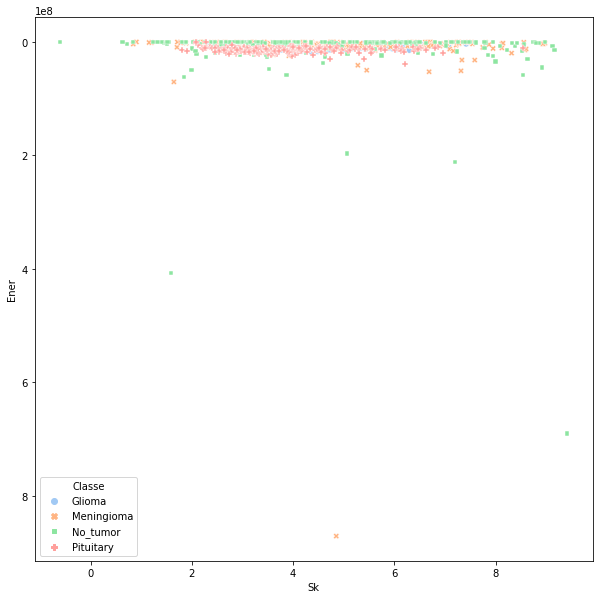

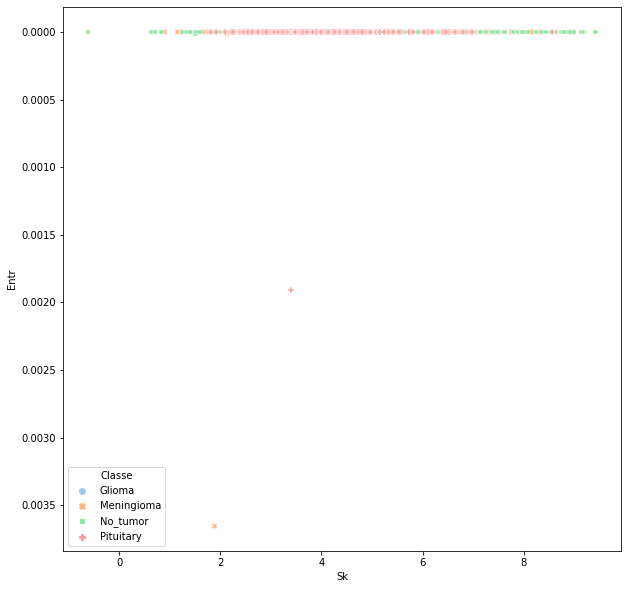

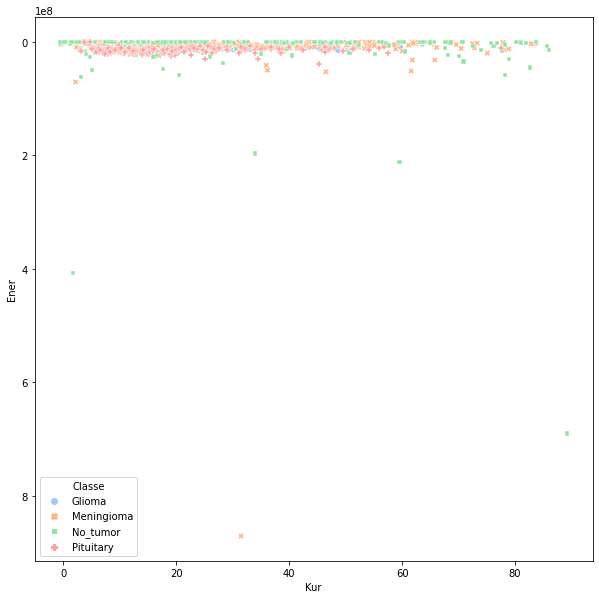

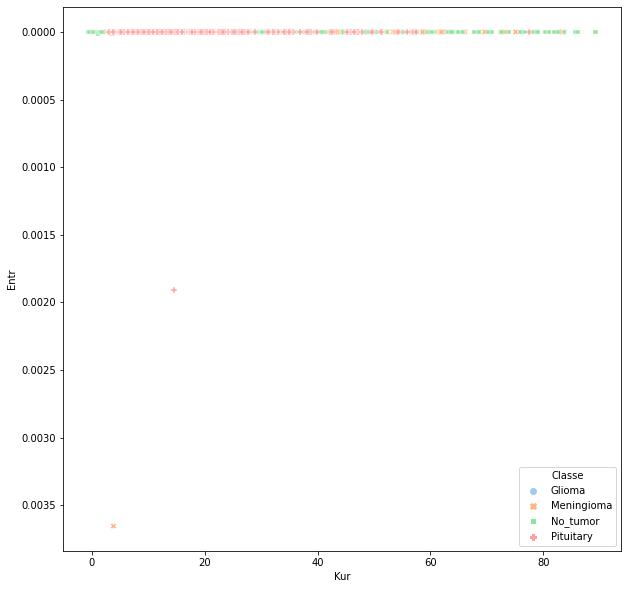

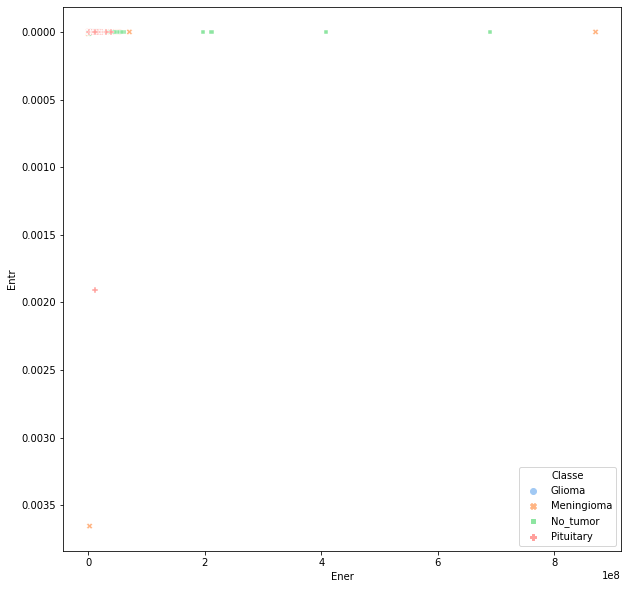

In [18]:
for i in range(len(names)):
    for j in range(i + 1,len(names)):
        plt.figure(figsize = (10,10))
        scat = sns.scatterplot(data=df, x=names[i], y=names[j], hue="Classe", style="Classe",palette='pastel')
        scatter_fig = scat.get_figure()
        scat.figure.savefig( 'plot/' + names[i] + '_' + names[j] + ".png",dpi=300)

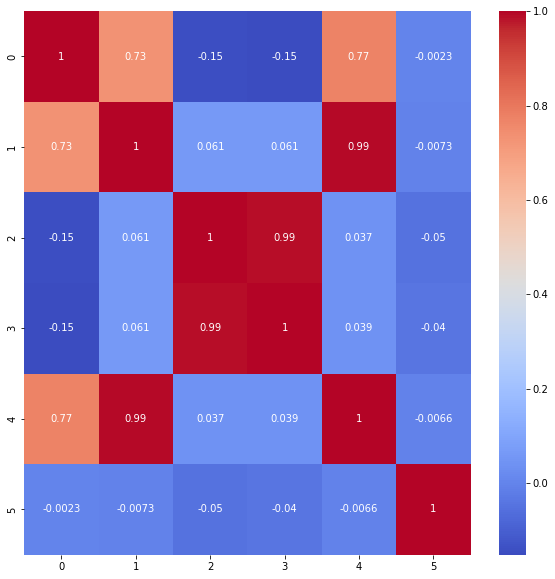

In [19]:
def torchToNumpy(x):
    return np.array([i.detach().numpy() for i in x])

mean = torchToNumpy(df['Mean'])
var = torchToNumpy(df['Var'])
sk = torchToNumpy(df['Sk'])
kur = torchToNumpy(df['Kur'])
ener = torchToNumpy(df['Ener'])
entr = torchToNumpy(df['Entr'])

corr = np.array([mean,var,sk,kur,ener,entr])
 
mCorr = np.corrcoef(corr)
plt.figure(figsize = (10,10))
sns.heatmap(mCorr, annot = True, cmap = 'coolwarm')
scat.figure.savefig( 'plot/' + "Mapa.png",dpi=300)

In [20]:
corr = np.transpose(corr)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
dim = pca.fit_transform(corr)
dfDim = pd.DataFrame(data = dim, columns = ['Dim1', 'Dim2'])
dfDim['Classe'] = lab
df

,Mean,Var,Sk,Kur,Ener,Entr,Classe
0,tensor(1458.5601),tensor(9027647.),tensor(3.6141),tensor(14.5812),tensor(11155042.),tensor(-0.),Glioma
1,tensor(1342.4800),tensor(4991816.5000),tensor(2.9771),tensor(11.1720),tensor(6794068.5000),tensor(-0.),Glioma
2,tensor(1292.5800),tensor(3641014.7500),tensor(2.8939),tensor(11.5950),tensor(5311778.),tensor(-0.),Glioma
3,tensor(1358.),tensor(6285252.5000),tensor(3.3330),tensor(13.6897),tensor(8129416.5000),tensor(-0.),Glioma
4,tensor(1522.8000),tensor(9165743.),tensor(6.1145),tensor(45.7099),tensor(11484663.),tensor(-0.),Glioma
...,...,...,...,...,...,...,...
1080,tensor(1980.7500),tensor(10759503.),tensor(2.6335),tensor(6.5057),tensor(14682873.),tensor(-0.),Pituitary
1081,tensor(1533.),tensor(6863005.5000),tensor(5.2351),tensor(36.8428),tensor(9213094.),tensor(-0.),Pituitary
1082,tensor(1583.6000),tensor(9824276.),tensor(5.4112),tensor(38.1729),tensor(12332066.),tensor(-0.),Pituitary
1083,tensor(1610.1400),tensor(8421625.),tensor(4.5107),tensor(27.5969),tensor(11014177.),tensor(-0.),Pituitary


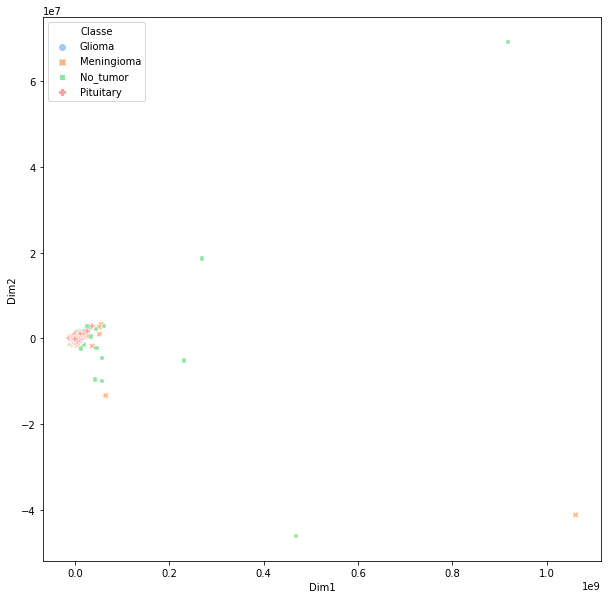

In [22]:
plt.figure(figsize = (10,10))
scat = sns.scatterplot(data=dfDim, x="Dim1", y="Dim2", hue="Classe", style="Classe",palette='pastel')
scatter_fig = scat.get_figure()
scat.figure.savefig( 'plot/' + "Pca.png",dpi=300)


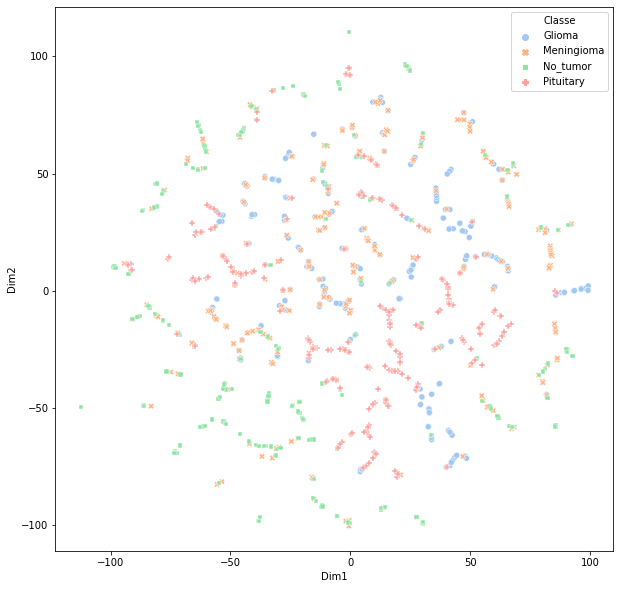

In [23]:
from sklearn.manifold import TSNE
dim = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(corr)
dfDim = pd.DataFrame(data = dim, columns = ['Dim1', 'Dim2'])
dfDim['Classe'] = lab
plt.figure(figsize = (10,10))
scat = sns.scatterplot(data=dfDim, x="Dim1", y="Dim2", hue="Classe", style="Classe",palette='pastel')
scatter_fig = scat.get_figure()
scat.figure.savefig( 'plot/' + "TSNE.png",dpi=300)

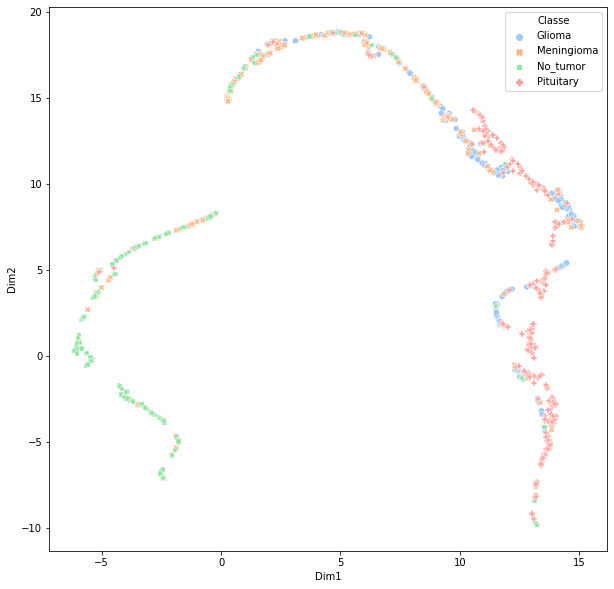

In [24]:
import umap
reducer = umap.UMAP()
dim = reducer.fit_transform(corr)
dfDim = pd.DataFrame(data = dim, columns = ['Dim1', 'Dim2'])
dfDim['Classe'] = lab
plt.figure(figsize = (10,10))
scat = sns.scatterplot(data=dfDim, x="Dim1", y="Dim2", hue="Classe", style="Classe",palette='pastel')
scatter_fig = scat.get_figure()
scat.figure.savefig( 'plot/' + "UMAP.png",dpi=300)
